# Accessibility for Competing Destintion models

I needed to replicate the CD model for my research and found out no function that would help me to estimate the accessibility term exist yet.

Here I am trying to build this function, in different ways, compare their computational time, and see if I can speed it up to accomodate a big data.

## Accessibility term

$A_{ij}$ represents the accessibility of destination $j$ to all other destinations available to origin $i$ as perceived by the
residents of origin $i$ and is defined as

![png](./acc1.png)

This can be little confusing, so let's break it down.

Imagine a migration between 5 following English cities, where pople from Liverpool migrate to South Hampton, Bristol and London, and from London to Brighton.
We want to calculate the accessibility term for the flow Liverpool to Bristol.

Here the accessibility of $\text{flow}_{Li,B}$ is the sum of the connections between the destination (Bristol) to all other destinations. This connection or accessibility between Bristol and other destinations can be then calculated as the distance between Bristol and destination times the mass of the destination. 

![png](./Graph_acc.png)

In other words;

$$  \text{Accessibility for the flow between Liverpool and Bristol} = \sum \text{population SH * distance1, population Lo * distance2} $$
                                                                                 
                                                                                 
**Important**: We don't necesserily know if this is ment as an accesibility of all possible destinations in a system, or only those that actually exist for given origin. 

I design 2 functions

    1. AFAP = Accessibility of flow taking all possible destinations in the system 
    2. AFOE = Accessibility of flow taking only existing destinations

In those two function, we will assume that the inputs are 3 data frames matching each other
    * DF of flows combination
    * DF of all possible flows in system and distances between them
    * DF of all points with their masses
    
![png](./table1.png)
    
Additionally, I have refined those into 1 function only, that can handle both situations and is presumably quicker (will see abouyt that).
This I function takes one Data Frame of all possible flow combinations, their distances, weight on the flow (this indicates if flow exists or not) and destination masses

    3. AFED = Accessibility of flow taking existing destinations

![png](./table2.png)
    
## Define the Functions

In [1]:
# 1. AFAP = Accessibility of flow taking all possible destinations in the system 

def AFAP(distances_df, dest_masses_df, flow_df, row_index): # AFAPF
    # rename teh columns so we can call them 
    distances_df = distances_df.rename(columns = {distances_df.columns[0]:'origin_ID', distances_df.columns[1]:'dest_ID', distances_df.columns[2]:'weight'})
    dest_masses_df = dest_masses_df.rename(columns = {dest_masses_df.columns[0]:'ID', dest_masses_df.columns[1]:'mass'})
    flow_df = flow_df.rename(columns = {flow_df.columns[0]:'origin_ID', flow_df.columns[1]:'dest_ID'})
    
    # define the variables
    all_dest = flow_df['dest_ID'].unique()
    D = flow_df['dest_ID'][row_index]
    O = flow_df['origin_ID'][row_index]
    
    # create flow arrays
    all_dest = np.delete(all_dest,np.where(all_dest == O))
    D_array = np.array([D]*len(all_dest), dtype=object)
    
    # Create all destination flows except origin
    x1 = pd.DataFrame({'D': D_array, 'dests':all_dest})
    
    # merge with the distances and masses
    x2 = x1.merge(distances_df, how='left', left_on=['D','dests'], right_on=['origin_ID','dest_ID'])
    x3 = x2.merge(dest_masses_df, how='left', left_on=['dest_ID'], right_on=['ID'])
    
    # calculate the accessibility
    x3['A'] = x3['weight']*x3['mass']
    A = x3['A'].sum()

    return A

In [2]:
# 2. AFOE = Accessibility of flow taking only existing destinations

def AFOE(distances_df, dest_masses_df, flow_df, row_index): # AFEF
    # rename teh columns so we can call them 
    distances_df = distances_df.rename(columns = {distances_df.columns[0]:'origin_ID', distances_df.columns[1]:'dest_ID', distances_df.columns[2]:'weight'})
    dest_masses_df = dest_masses_df.rename(columns = {dest_masses_df.columns[0]:'ID', dest_masses_df.columns[1]:'mass'})
    flow_df = flow_df.rename(columns = {flow_df.columns[0]:'origin_ID', flow_df.columns[1]:'dest_ID'})
    
    # define the variables
    D = flow_df['dest_ID'][row_index]
    O = flow_df['origin_ID'][row_index]
    all_dest = flow_df.loc[flow_df['origin_ID']==O,:]['dest_ID'].unique()
    
    # create flow arrays
    all_dest = np.delete(all_dest,np.where(all_dest == O))
    D_array = np.array([D]*len(all_dest), dtype=object)
    
    # Create all destination flows except origin
    x1 = pd.DataFrame({'D': D_array, 'dests':all_dest})
    
    # merge with the distances and masses
    x2 = x1.merge(distances_df, how='left', left_on=['D','dests'], right_on=['origin_ID','dest_ID'])
    x3 = x2.merge(dest_masses_df, how='left', left_on=['dest_ID'], right_on=['ID'])
    
    # calculate the accessibility
    x3['A'] = x3['weight']*x3['mass']
    A = x3['A'].sum()

    return A

In [3]:
# 3. AFED = Accessibility of flow taking existing destinations

def AFED(flow_df, row_index): # AFAPF
    
    # rename teh columns so we can call them 
    flow_df = flow_df.rename(columns = {flow_df.columns[0]:'origin_ID', 
                                            flow_df.columns[1]:'dest_ID', 
                                            flow_df.columns[2]:'dist', 
                                            flow_df.columns[3]:'weight', 
                                            flow_df.columns[4]:'dest_mass'})
    # define O and D for each row the variables
    D = flow_df['dest_ID'][row_index]
    O = flow_df['origin_ID'][row_index]
    
    # get the list of possible destinations
    all_dest = (flow_df.query('origin_ID == @O')
                .query('weight > 0')
                ['dest_ID']
                .unique()
               )    
    
    # Create all destination flows 
    x1 = pd.DataFrame({'D': np.array([D]*len(all_dest), dtype=object), 
                       'dests':all_dest}).merge(flow_df, how='left', left_on=['D','dests'], right_on=['origin_ID','dest_ID'])
    
    # merge with the distances and masses 
    
    # calculate the accessibility
    A = (x1['weight']*x1['dest_mass']).sum()

    return A

## Load packages

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools
from geopy.distance import geodesic, great_circle
from timeit import default_timer as timer
import time

## Define the test data

### Load sample points

In [5]:
pois = gpd.read_file("./points.geojson")


pois.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID_code   855 non-null    object  
 1   X         855 non-null    float64 
 2   Y         855 non-null    float64 
 3   geometry  855 non-null    geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 26.8+ KB


In [6]:
# strip
pois_all = pois.iloc[:,[0,3]]

# Add random masses
pois_all['mass'] = pd.Series( np.random.randint(0,1500, size=len(pois_all))
                            )
# create stripped column of coordinates 
pois_all['xy'] = pois_all.geometry.apply(lambda x: [x.y, x.x])

# get all unique combinations of all the origins and destinations
flow_all = pd.DataFrame( list( itertools.product( pois_all['ID_code'].unique(),pois_all['ID_code'].unique())
                             )
                       ).rename(columns = {0:'origin',
                                        1:'destination'})

# joining the xy to flows and create distances
distances_all = flow_all.merge(pois_all.loc[:,['ID_code','xy']], how = 'left', left_on = 'origin', right_on = 'ID_code' 
                        ).merge(pois_all.loc[:,['ID_code','xy']], how = 'left', left_on = 'destination', right_on = 'ID_code'
                               )


# calculate distances
distances_all['great_circle_dist'] = distances_all.apply(lambda x: great_circle(x.xy_x, x.xy_y).km, axis=1)
distances_all = distances_all.loc[:,['origin','destination','great_circle_dist']]

C:\Users\tk18583\Anaconda3\envs\graphs\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [7]:
flow_all.head()

,origin,destination
0,A91120,A91120
1,A91120,A99931
2,A91120,A99986
3,A91120,L81002
4,A91120,L81004


In [8]:
distances_all.head()

,origin,destination,great_circle_dist
0,A91120,A91120,0.000000
1,A91120,A99931,5.490762
2,A91120,A99986,2.598773
3,A91120,L81002,30.232818
4,A91120,L81004,14.588663


In [9]:
pois_all.head()

,ID_code,geometry,mass,xy
0,A91120,POINT (-2.55906 51.50283),1445,"[51.502830094350216, -2.55906333659297]"
1,A99931,POINT (-2.59614 51.45918),1428,"[51.4591818706117, -2.596140188956506]"
2,A99986,POINT (-2.53883 51.48314),286,"[51.48314321496156, -2.538833345365197]"
3,L81002,POINT (-2.93035 51.36021),357,"[51.360206696542896, -2.930352226593651]"
4,L81004,POINT (-2.76732 51.48281),1149,"[51.482805431236095, -2.76731748987437]"


From this data, we create 6 subsets of data for different number of points

In [10]:
# list points
list5 = list(pois_all['ID_code'][0:6])
list10 = list(pois_all['ID_code'][0:11])
list20 = list(pois_all['ID_code'][0:21])
list40 = list(pois_all['ID_code'][0:41])
list80 = list(pois_all['ID_code'][0:81])
list160 = list(pois_all['ID_code'][0:161])

In [11]:
# Define different number of points
pois_all_s = pd.DataFrame(pois_all.loc[:,['ID_code','mass']])
pois5 = pois_all_s[pois_all_s['ID_code'].isin(list5)]
pois10 = pois_all_s[pois_all_s['ID_code'].isin(list10)]
pois20 = pois_all_s[pois_all_s['ID_code'].isin(list20)]
pois40 = pois_all_s[pois_all_s['ID_code'].isin(list40)]
pois80 = pois_all_s[pois_all_s['ID_code'].isin(list80)]
pois160 = pois_all_s[pois_all_s['ID_code'].isin(list160)]

In [12]:
flow5 = flow_all[flow_all['origin'].isin(list5) & flow_all['destination'].isin(list5)].reset_index(drop=True)
flow10 = flow_all[flow_all['origin'].isin(list10) & flow_all['destination'].isin(list10)].reset_index(drop=True)
flow20 = flow_all[flow_all['origin'].isin(list20) & flow_all['destination'].isin(list20)].reset_index(drop=True)
flow40 = flow_all[flow_all['origin'].isin(list40) & flow_all['destination'].isin(list40)].reset_index(drop=True)
flow80 = flow_all[flow_all['origin'].isin(list80) & flow_all['destination'].isin(list80)].reset_index(drop=True)
flow160 = flow_all[flow_all['origin'].isin(list160) & flow_all['destination'].isin(list160)].reset_index(drop=True)

In [13]:
distances5 = distances_all[distances_all['origin'].isin(list5) & distances_all['destination'].isin(list5)].reset_index(drop=True)
distances10 = distances_all[distances_all['origin'].isin(list10) & distances_all['destination'].isin(list10)].reset_index(drop=True)
distances20 = distances_all[distances_all['origin'].isin(list20) & distances_all['destination'].isin(list20)].reset_index(drop=True)
distances40 = distances_all[distances_all['origin'].isin(list40) & distances_all['destination'].isin(list40)].reset_index(drop=True)
distances80 = distances_all[distances_all['origin'].isin(list80) & distances_all['destination'].isin(list80)].reset_index(drop=True)
distances160 = distances_all[distances_all['origin'].isin(list160) & distances_all['destination'].isin(list160)].reset_index(drop=True)

**Now what if some flows just does not exist**

In [14]:
li_ommited = [1,4,5,9,13,15,17,26,27,28,34]

flow5_ommited = flow5.drop(flow5.index[li_ommited]).reset_index(drop=True)
flow10_ommited = flow10.drop(flow10.index[li_ommited]).reset_index(drop=True)
flow20_ommited = flow20.drop(flow20.index[li_ommited]).reset_index(drop=True)
flow40_ommited = flow40.drop(flow40.index[li_ommited]).reset_index(drop=True)
flow80_ommited = flow80.drop(flow80.index[li_ommited]).reset_index(drop=True)
flow160_ommited = flow160.drop(flow160.index[li_ommited]).reset_index(drop=True)

**Now get this all together for the last function**

In [15]:
# combine the points and distances
flow_integrated = distances_all.merge(pois_all_s, how = 'left', left_on=['destination'], right_on=['ID_code'])

#generate some weights
flow_integrated['weight'] = pd.Series( np.random.randint(-50,1500, size=len(flow_integrated)) # here - and 0 represent flows that does not exist
                                     )
# reorder
flow_integrated = flow_integrated.loc[:,['origin','destination','great_circle_dist','weight','mass']]

# build short datasets
flow5_integrated = flow_integrated[flow_integrated['origin'].isin(list5) & flow_integrated['destination'].isin(list5)].reset_index(drop=True)
flow10_integrated = flow_integrated[flow_integrated['origin'].isin(list10) & flow_integrated['destination'].isin(list10)].reset_index(drop=True)
flow20_integrated = flow_integrated[flow_integrated['origin'].isin(list20) & flow_integrated['destination'].isin(list20)].reset_index(drop=True)
flow40_integrated = flow_integrated[flow_integrated['origin'].isin(list40) & flow_integrated['destination'].isin(list40)].reset_index(drop=True)
flow80_integrated = flow_integrated[flow_integrated['origin'].isin(list80) & flow_integrated['destination'].isin(list80)].reset_index(drop=True)
flow160_integrated = flow_integrated[flow_integrated['origin'].isin(list160) & flow_integrated['destination'].isin(list160)].reset_index(drop=True)

In [16]:
flow_integrated.head()

,origin,destination,great_circle_dist,weight,mass
0,A91120,A91120,0.000000,1209,1445
1,A91120,A99931,5.490762,238,1428
2,A91120,A99986,2.598773,1113,286
3,A91120,L81002,30.232818,1463,357
4,A91120,L81004,14.588663,809,1149


## Apply the function

In [17]:
# 1 row of data
start = timer()

print('result: '+str(AFAP(distances_df=distances5, dest_masses_df = pois5, flow_df=flow5, row_index=1)))

end = timer()
print('time: ' + str(end - start))

result: 27192.491380458963
time: 0.014679999999998472


In [18]:
# for 05 dataset function 1
start = timer()

A_ij = []
for idx in flow5.index:
    A = AFAP(distances_df=distances5, dest_masses_df = pois5, flow_df=flow5, row_index=idx)
    A_ij.append(A)

end = timer()
print(A_ij)
print('time: ' + str(end - start))

[41189.24235921584, 27192.491380458963, 39946.44607258053, 78623.15183993989, 36076.31596226781, 37001.19555635461, 33348.43481917858, 35126.64186740137, 36874.92900397954, 85666.9652958998, 39815.26134732392, 43770.71107578189, 40445.993272278334, 33759.38079440098, 43701.673102736866, 113616.57621813065, 52631.913835622836, 49110.33421065483, 30396.126301286513, 25965.989696581822, 32850.62344996119, 122309.57397917779, 50834.51029868698, 42292.93800813396, 24426.868780066427, 21173.15336989341, 25522.48476222668, 101960.93384101187, 57156.93373587167, 33511.90264334364, 36139.54626405348, 32415.55222827031, 39612.209122199536, 109370.66872172894, 49269.73349958515, 51421.77037356723]
time: 0.19020680000000567


In [19]:
# for 05 dataset function 2
start = timer()

A_ij = []
for idx in flow5_ommited.index:
    A = AFOE(distances_df=distances5, dest_masses_df = pois5, flow_df=flow5_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
print(A_ij)
print('time: ' + str(end - start))

[11536.365144866819, 10851.04965277568, 8692.997761047147, 22555.318761249262, 25965.989696581822, 26023.879351203857, 33492.83791013923, 34641.87871034862, 16762.373579149407, 21934.415370666527, 21080.617773603866, 30396.126301286513, 25965.989696581822, 32850.62344996119, 122309.57397917779, 50834.51029868698, 42292.93800813396, 12890.503635199608, 10645.240126073475, 22071.634114997963, 19377.17268490407, 18462.063730762347, 21433.02078168935, 89022.02858356302, 33511.90264334364]
time: 0.13956089999999932


In [20]:
# for 05 dataset function 3
start = timer()

A_ij = []
for idx in flow5_integrated.index:
    A = AFED(flow_df=flow5_integrated, row_index=idx)
    A_ij.append(A)

end = timer()
print(A_ij)
print('time: ' + str(end - start))

[4107489, 2961600, 4825321, 3355995, 4809233, 5678556, 4107489, 2961600, 4825321, 3355995, 4809233, 5678556, 4107489, 2961600, 4825321, 3355995, 4809233, 5678556, 4107489, 2961600, 4825321, 3355995, 4809233, 5678556, 4107489, 2961600, 4825321, 3355995, 4809233, 5678556, 4107489, 2961600, 4825321, 3355995, 4809233, 5678556]
time: 0.2311064000000016


In [21]:
# for 80 dataset function 2
start = timer()

A_ij = []
for idx in flow80_ommited.index:
    A = AFOE(distances_df=distances80, dest_masses_df = pois80, flow_df=flow80_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
print('time: ' + str(end - start))

time: 37.4103371


**From this it looks like the last function is actually the slowest**

## Lets have a look at how they perform for different lenght data

I honestly did not know how to turn this into function...

In [22]:
# for 05 dataset function 1
list_AFAP = []

# 05
start = timer()

A_ij = []
for idx in flow5.index:
    A = AFAP(distances_df=distances5, dest_masses_df = pois5, flow_df=flow5, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFAP.append(t)

# 010
start = timer()

A_ij = []
for idx in flow10.index:
    A = AFAP(distances_df=distances10, dest_masses_df = pois10, flow_df=flow10, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFAP.append(t)

# 020
start = timer()

A_ij = []
for idx in flow20.index:
    A = AFAP(distances_df=distances20, dest_masses_df = pois20, flow_df=flow20, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFAP.append(t)

# 040
start = timer()

A_ij = []
for idx in flow40.index:
    A = AFAP(distances_df=distances40, dest_masses_df = pois40, flow_df=flow40, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFAP.append(t)

# 080
start = timer()

A_ij = []
for idx in flow80.index:
    A = AFAP(distances_df=distances80, dest_masses_df = pois80, flow_df=flow80, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFAP.append(t)

# 0160
start = timer()

A_ij = []
for idx in flow160.index:
    A = AFAP(distances_df=distances160, dest_masses_df = pois160, flow_df=flow160, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFAP.append(t)

In [23]:
list_AFAP

[0.1933359000000081,
 0.5314505000000054,
 1.9356877000000026,
 7.777656399999998,
 36.491979,
 243.75670110000002]

In [24]:
# for 05 dataset function 2
list_AFOE = []

# 05
start = timer()
A_ij = []
for idx in flow5_ommited.index:
    A = AFOE(distances_df=distances5, dest_masses_df = pois5, flow_df=flow5_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFOE.append(t)

# 10
start = timer()
A_ij = []
for idx in flow10_ommited.index:
    A = AFOE(distances_df=distances10, dest_masses_df = pois10, flow_df=flow10_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFOE.append(t)

# 20
start = timer()
A_ij = []
for idx in flow20_ommited.index:
    A = AFOE(distances_df=distances20, dest_masses_df = pois20, flow_df=flow20_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFOE.append(t)

# 40
start = timer()
A_ij = []
for idx in flow40_ommited.index:
    A = AFOE(distances_df=distances40, dest_masses_df = pois40, flow_df=flow40_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFOE.append(t)

# 80
start = timer()
A_ij = []
for idx in flow80_ommited.index:
    A = AFOE(distances_df=distances80, dest_masses_df = pois80, flow_df=flow80_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFOE.append(t)

# 160
start = timer()
A_ij = []
for idx in flow160_ommited.index:
    A = AFOE(distances_df=distances160, dest_masses_df = pois160, flow_df=flow160_ommited, row_index=idx)
    A_ij.append(A)

end = timer()
t = (end - start)
list_AFOE.append(t)

In [25]:
list_AFOE

[0.2114847999999938,
 0.6925498999999604,
 2.8162843000000066,
 11.239143099999978,
 39.809338500000024,
 250.31331749999998]

In [26]:
# for 05 dataset function 3
list_AFED = []

# 5
start = timer()
A_ij = []
for idx in flow5_integrated.index:
    A = AFED(flow_df=flow5_integrated, row_index=idx)
    A_ij.append(A)
end = timer()
t = (end - start)
list_AFED.append(t)

# 10
start = timer()
A_ij = []
for idx in flow10_integrated.index:
    A = AFED(flow_df=flow10_integrated, row_index=idx)
    A_ij.append(A)
end = timer()
t = (end - start)
list_AFED.append(t)

# 20
start = timer()
A_ij = []
for idx in flow20_integrated.index:
    A = AFED(flow_df=flow20_integrated, row_index=idx)
    A_ij.append(A)
end = timer()
t = (end - start)
list_AFED.append(t)

# 40
start = timer()
A_ij = []
for idx in flow40_integrated.index:
    A = AFED(flow_df=flow40_integrated, row_index=idx)
    A_ij.append(A)
end = timer()
t = (end - start)
list_AFED.append(t)

# 80
start = timer()
A_ij = []
for idx in flow80_integrated.index:
    A = AFED(flow_df=flow80_integrated, row_index=idx)
    A_ij.append(A)
end = timer()
t = (end - start)
list_AFED.append(t)

# 160
start = timer()
A_ij = []
for idx in flow160_integrated.index:
    A = AFED(flow_df=flow160_integrated, row_index=idx)
    A_ij.append(A)
end = timer()
t = (end - start)
list_AFED.append(t)

In [27]:
list_AFED

[0.21201880000000983,
 0.6737305000000333,
 2.6249341999999842,
 11.172200100000055,
 46.07898059999991,
 252.50430440000002]

In [28]:
times = pd.DataFrame({'AFAP': pd.Series(list_AFAP),
                     'AFOE': pd.Series(list_AFOE),
                     'AFED': pd.Series(list_AFED)})
times

,AFAP,AFOE,AFED
0,0.193336,0.211485,0.212019
1,0.531451,0.692550,0.673731
2,1.935688,2.816284,2.624934
3,7.777656,11.239143,11.172200
4,36.491979,39.809339,46.078981
5,243.756701,250.313317,252.504304


In [41]:
str(len(flow5))

'36'

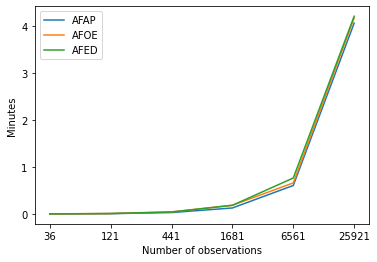

In [43]:
(times.iloc[:,0:3]/60).plot()
plt.xlabel("Number of observations")
plt.ylabel("Minutes")
plt.xticks(times.index, (str(len(flow5)), str(len(flow10)), str(len(flow20)), str(len(flow40)),str(len(flow80)), str(len(flow160))));

Time per one row

In [46]:
li_n = [len(flow5), len(flow10), len(flow20), len(flow40), len(flow80), len(flow160)]
times['AFAP_1'] = times['AFAP']/pd.Series(li_n)
times['AFOE_1'] = times['AFOE']/pd.Series(li_n)
times['AFED_1'] = times['AFED']/pd.Series(li_n)

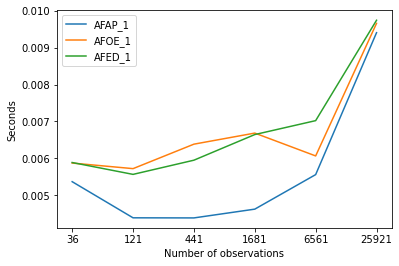

In [47]:
times.iloc[:,3:6].plot()
plt.xlabel("Number of observations")
plt.ylabel("Seconds")
plt.xticks(times.index, (str(len(flow5)), str(len(flow10)), str(len(flow20)), str(len(flow40)),str(len(flow80)), str(len(flow160))));

In [45]:
len(flow_all)

731025

### How long will it take to do whole dataset?

Ok it will take something between and 0.5 to 2.5 hours to compute a dataset...probably

In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [51]:
times['observations'] = pd.Series(li_n)
times

,AFAP,AFOE,AFED,AFAP_1,AFOE_1,AFED_1,observations
0,0.193336,0.211485,0.212019,0.005370,0.005875,0.005889,36
1,0.531451,0.692550,0.673731,0.004392,0.005724,0.005568,121
2,1.935688,2.816284,2.624934,0.004389,0.006386,0.005952,441
3,7.777656,11.239143,11.172200,0.004627,0.006686,0.006646,1681
4,36.491979,39.809339,46.078981,0.005562,0.006068,0.007023,6561
5,243.756701,250.313317,252.504304,0.009404,0.009657,0.009741,25921


In [127]:
y = np.log(times['AFED']).values.reshape(-1,1)
x = np.log(times['observations']).values.reshape(-1,1)
model = LinearRegression().fit(x, y)

In [128]:
len(flow_all)

731025

In [129]:
pred = times.loc[:,['observations']]
pred.loc[6,['observations']] = len(flow_all)

pred['predicted'] = np.exp(model.predict(np.log(pred).values.reshape(-1,1)).flatten())
pred

,observations,predicted
0,36.0,0.190233
1,121.0,0.698249
2,441.0,2.795497
3,1681.0,11.743519
4,6561.0,50.600749
5,25921.0,220.891228
6,731025.0,7939.619233


In [130]:
pred['min'] = pred['predicted']/60
pred['h'] = pred['min']/60
pred

,observations,predicted,min,h
0,36.0,0.190233,0.003171,0.000053
1,121.0,0.698249,0.011637,0.000194
2,441.0,2.795497,0.046592,0.000777
3,1681.0,11.743519,0.195725,0.003262
4,6561.0,50.600749,0.843346,0.014056
5,25921.0,220.891228,3.681520,0.061359
6,731025.0,7939.619233,132.326987,2.205450


In [131]:
# this is probably worng, it could as well be 16 hours
r1 = 0.006646-0.005952
r2 = 0.007023-0.006646
r3 = 0.009741-0.007023

f = 731025.0/25921.0
i_d = f*r3
pu = 0.007023+i_d
((pu*len(flow_all))/60)/60

16.991485458501312

What about the migration data? there is 121104 rows

In [134]:
predm = pred.loc[:,['observations']]
predm.loc[7,['observations']] = 121104
predm['predicted'] = np.exp(model.predict(np.log(predm).values.reshape(-1,1)).flatten())
predm

,observations,predicted
0,36.0,0.190233
1,121.0,0.698249
2,441.0,2.795497
3,1681.0,11.743519
4,6561.0,50.600749
5,25921.0,220.891228
6,731025.0,7939.619233
7,121104.0,1154.289236


In [135]:
predm['min'] = predm['predicted']/60
predm['h'] = predm['min']/60
predm

,observations,predicted,min,h
0,36.0,0.190233,0.003171,0.000053
1,121.0,0.698249,0.011637,0.000194
2,441.0,2.795497,0.046592,0.000777
3,1681.0,11.743519,0.195725,0.003262
4,6561.0,50.600749,0.843346,0.014056
5,25921.0,220.891228,3.681520,0.061359
6,731025.0,7939.619233,132.326987,2.205450
7,121104.0,1154.289236,19.238154,0.320636


Ok it will take something between and 0.5 to 2.5 hours to compute a dataset...great

## Can we speed it up?

In [33]:
from multiprocessing import Pool
import multiprocessing

In [34]:
multiprocessing.cpu_count()

12

In [35]:
# 3. AFED = Alter

def A_M(row_index, flow_df = flow40_integrated): 
    
    # rename teh columns so we can call them 
    flow_df = flow_df.rename(columns = {flow_df.columns[0]:'origin_ID', 
                                            flow_df.columns[1]:'dest_ID', 
                                            flow_df.columns[2]:'dist', 
                                            flow_df.columns[3]:'weight', 
                                            flow_df.columns[4]:'dest_mass'})
    # define O and D for each row the variables
    D = flow_df['dest_ID'][row_index]
    O = flow_df['origin_ID'][row_index]
    
    # get the list of possible destinations
    all_dest = (flow_df.query('origin_ID == @O')
                .query('weight > 0')
                ['dest_ID']
                .unique()
               )    
    
    # Create all destination flows 
    x1 = pd.DataFrame({'D': np.array([D]*len(all_dest), dtype=object), 
                       'dests':all_dest}).merge(flow_df, how='left', left_on=['D','dests'], right_on=['origin_ID','dest_ID'])
    
    # merge with the distances and masses 
    
    # calculate the accessibility
    A = (x1['weight']*x1['dest_mass']).sum()

    return A

cups = 4


with Pool(cups) as pool:
    accessibilities_2 = pool.map(A_M, flow40_integrated.index)

def main():
    pool = Pool(processes=3)  # set the processes max number 3
    result = pool.map(A_M, flow40_integrated.index)
    pool.close()
    pool.join()
    print(result)
    print('end')


if __name__ == "__main__":
    main()

**This is not working for some reason, it runs and never ends**